<a href="https://colab.research.google.com/github/mich3leRusso/Deep_learning_last/blob/main/u_net_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample submission based on 3D U-Net as a baseline

In this notebook, we'll go through a full attempt at a solution - albeit a poorly performing one.

**Full disclosure:** this notebook was not developed on Kaggle, but on another machine. It may not work out of the box but hopefully, it can serve as a useful starting point for now.

The idea is to train a 3D U-Net to segment the bugs based on the single bug images. Here, there is only one bug per image, so we can use the 3D U-Net to segment the bug. Since we know the label of the bugs in the single bug images, we can also train the U-Net to predict the bug type, by casting it as a multi-class segmentation problem (13 classes, 12 bugs + background). We can then use the segmentation to find its center point and use that for our submission.

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'bugnist2024fgvc:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F71698%2F7906362%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240503%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240503T144345Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D62948ba0cef5adfbb68a95c247dfe452fed1c1559170dcb5a4baa2fe671ebddda2d43f92f30ce04c2446539962bcc9ccc55a0a57389941e43720a5bab8a9697d190a6ed0561be006eb07be652fe0a067c0c64ba899dbfdfb9df33d460f67be4a11accda17850778b00ad915543b40f25b132da7111a294ee94121f396112b8936406b2bf0574bafc11c633ad0fbc7d70b196f34cd0d9ebcb77b75c99d5db3ca51bc707b5455a031dec98dd8a6fe0646b04859da5b433d92534de7b37c9b7e3970113b909d1dc9a94e1601f49773dadb573e4292d175e38c1f5960675436c69542e09a1b0986fb4aea40cad69a440215e78a961cd150f86274e1d2701d8fe50bd'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 709799651 bytes downloaded
Downloaded and uncompressed: bugnist2024fgvc
Data source import complete.


In [2]:
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [9]:
import os
import glob

import monai
import numpy as np
import torch
from tqdm import tqdm, trange


import numpy as np
import pandas as pd
import os
import tifffile

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from skimage import measure
from skimage import io



In [24]:

data_dir = '/kaggle/input/bugnist2024fgvc/BugNIST_DATA/train'
data_val='/kaggle/input/bugnist2024fgvc/BugNIST_DATA/validation'

First, we gather all the files and their labels to prepare the data loaders.
We will store the labels as one-hot encoded vectors.

In [13]:
images = []
labels = []

class_names = os.listdir(data_dir)
class_image_files = [
    glob.glob(os.path.join(data_dir, name, '*')) for name in class_names
]

for i, files in enumerate(class_image_files):
    images += files

    labels_i = torch.zeros(len(files), len(class_names))
    labels_i[:, i] = 1
    labels.append(labels_i)


labels = torch.cat(labels, dim=0)

Some samples of the lists we made:

In [14]:
class_names

['WO', 'GH', 'BC', 'AC', 'ML', 'CF', 'BL', 'BF', 'BP', 'MA', 'PP', 'SL']

In [15]:
images[:5]

['/kaggle/input/bugnist2024fgvc/BugNIST_DATA/train/WO/bank_8_000.tif',
 '/kaggle/input/bugnist2024fgvc/BugNIST_DATA/train/WO/bank_4_065.tif',
 '/kaggle/input/bugnist2024fgvc/BugNIST_DATA/train/WO/bank_7_044.tif',
 '/kaggle/input/bugnist2024fgvc/BugNIST_DATA/train/WO/bank_8_007.tif',
 '/kaggle/input/bugnist2024fgvc/BugNIST_DATA/train/WO/bank_4_079.tif']

In [16]:
labels[:5]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

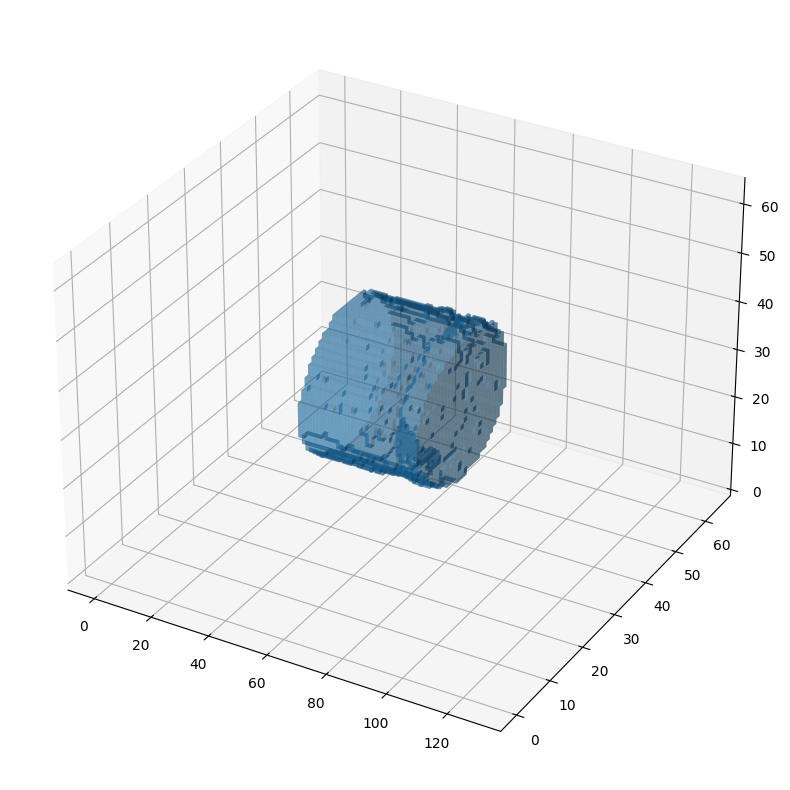

In [49]:
#plot the bugs
img = tifffile.imread(images[0])

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = '3d')

ax.voxels(img, alpha = 0.4, cmap = 'magma')

plt.show()

In [47]:
def plot_surface(filepath):
    """
    This function calculates the surfaces (using marching cubes), and displays them in 3D

    """

    img = tifffile.imread(filepath)
    print("shape of the images: ", img.shape)
    # use marching cubes to extract the surface
    verts, faces, _, _ = measure.marching_cubes(img, level = 42)
    print("vertex representation: ",verts)
    print("vertex shape: ", verts.shape)
    print(faces)

    # plot
    fig = go.Figure(data = [go.Mesh3d(x = verts[:, 0], y = verts[:, 1], z = verts[:, 2],
                                     i = faces[:, 0], j = faces[:, 1], k = faces[:, 2],
                                     opacity = 0.5)])

    fig.update_layout(scene = dict(xaxis = dict(title='X'),
                                 yaxis = dict(title='Y'),
                                 zaxis = dict(title='Z')),
                      margin = dict(l = 0, r  =0, t = 0, b = 0),
                      title = filepath)

    fig.show()


In [41]:
# Plot surface for each filepath

plot_surface(images[20])

shape of the images:  (128, 64, 64)
vertex representation:  [[39.848484  43.        16.       ]
 [40.        43.        15.8529415]
 [40.        42.83871   16.       ]
 ...
 [91.64948   16.        42.       ]
 [91.421875  17.        41.       ]
 [91.333336  17.        42.       ]]
vertex shape:  (7857, 3)
[[   2    1    0]
 [   4    3    0]
 [   0    3    2]
 ...
 [7840 7855 7843]
 [7843 7855 7856]
 [7843 7856 7838]]


Shape of the first image:  (128, 64, 64)
Shape of the second image:  (128, 64, 64)
Verts1 shape: (6232, 3)
Faces1 shape: (12498, 3)
Verts2 shape: (5100, 3)
Faces2 shape: (10180, 3)


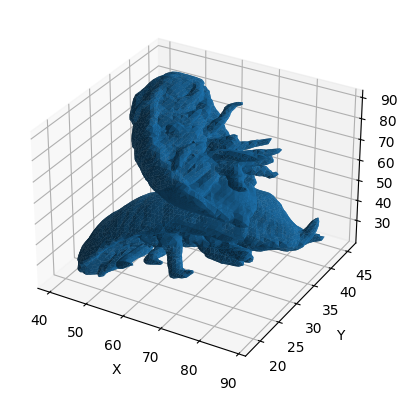

In [43]:
import numpy as np
from skimage import measure
import tifffile
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_surface(filepath1, filepath2):
    """
    This function calculates the surfaces (using marching cubes), and displays them in 3D
    """
    # Read the first image
    img1 = tifffile.imread(filepath1)
    print("Shape of the first image: ", img1.shape)

    # Read the second image
    img2 = tifffile.imread(filepath2)
    print("Shape of the second image: ", img2.shape)

    # Resize both images to (128, 64, 64)
    img1_resized = img1[:128, :64, :64]
    img2_resized = img2[:128, :64, :64]

    # Extract surface from the first image
    verts1, faces1, _, _ = measure.marching_cubes(img1_resized, level=42)
    print("Verts1 shape:", verts1.shape)
    print("Faces1 shape:", faces1.shape)

    # Extract surface from the second image
    verts2, faces2, _, _ = measure.marching_cubes(img2_resized, level=42)
    print("Verts2 shape:", verts2.shape)
    print("Faces2 shape:", faces2.shape)

    # Translate the vertices of the second surface to avoid overlap
    max_z = np.max(verts1[:, 2])
    verts2_translated = verts2 + [0, 0, max_z + 1]  # Shift along z-axis to avoid overlap

    # Combine vertices and faces of both surfaces
    combined_verts = np.vstack((verts1, verts2_translated))
    combined_faces = np.vstack((faces1, faces2 + len(verts1)))  # Adjust indices for second surface

    # Plot the combined surface
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_trisurf(combined_verts[:, 0], combined_verts[:, 1], combined_verts[:, 2], triangles=combined_faces)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()


# Example usage:
plot_surface(images[1], images[2])


(11332, 3)


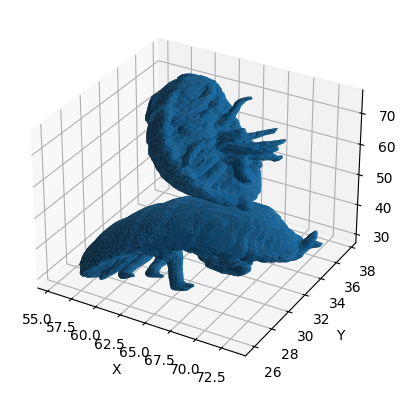

In [58]:
def reshape_points(verts,img):

    max_z = np.max(verts[:, 2])
    max_x = np.max(verts[:, 0])
    max_y = np.max(verts[:, 1])
    max_p=np.array([max_x,max_y,max_z])
    min_z = np.min(verts[:, 2])
    min_y = np.min(verts[:, 1])
    min_x = np.min(verts[:, 0])
    min_p=np.array([min_x,min_y,min_z])
    reshaped_points=verts*((max_p-min_p)/img.shape)+min_p
    return reshaped_points

def generate_combined_surface(filepath1, filepath2):
    """
    This function generates a numpy array representing the combined surface of two volumes.
    """
    # Read the first image
    img1 = tifffile.imread(filepath1)

    # Read the second image
    img2 = tifffile.imread(filepath2)

    # Resize both images to (128, 64, 64)
    img1_resized = img1[:128, :64, :64]
    img2_resized = img2[:128, :64, :64]

    # Extract surface from the first image
    verts1, faces1, _, _ = measure.marching_cubes(img1_resized, level=42)

    # Extract surface from the second image
    verts2, faces2, _, _ = measure.marching_cubes(img2_resized, level=42)

    # Translate the vertices of the second surface to avoid overlap
    verts_actual1=reshape_points(verts1,img1_resized)
    verts_actual2=reshape_points(verts2,img2_resized)
    max_z=np.max(verts_actual1[:,2])
    verts2_translated = verts_actual2 + [0, 0, max_z + 1]  # Shift along z-axis to avoid overlap


    # Combine vertices and faces of both surfaces
    combined_verts = np.vstack((verts_actual1, verts2_translated))
    combined_faces = np.vstack((faces1, faces2 + len(verts1)))  # Adjust indices for second surface
    print(combined_verts.shape)
     # Plot the combined surface
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_trisurf(combined_verts[:, 0], combined_verts[:, 1], combined_verts[:, 2], triangles=combined_faces)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()




# Example usage:
combined_surface = generate_combined_surface(images[1], images[2])


In [59]:
def find_center_mass(img):
  def plot_surface(img,draw=True):
    """
    This function calculates the surfaces (using marching cubes), and displays them in 3D
    """
    # use marching cubes to extract the surface, play around with the level value to see which level yields the best results
    verts, faces, _, _ = measure.marching_cubes(img, level = 42)

    # compute the faces and vertices
    dats = go.Mesh3d(x = verts[:, 0], y = verts[:, 1], z = verts[:, 2],
                                     i = faces[:, 0], j = faces[:, 1], k = faces[:, 2],
                                     opacity = 0.5)

    #extract the points and the means
    x_data = dats.x
    y_data = dats.y
    z_data = dats.z

    cenx, ceny, cenz = np.mean(x_data),np.mean(y_data),np.mean(z_data)
    center_point = (cenx,ceny,cenz)
    if draw:
        # plot
        fig = go.Figure(data = dats)
        fig.update_layout(scene = dict(xaxis = dict(title='Z'),
                                     yaxis = dict(title='Y'),
                                     zaxis = dict(title='X')),
                          margin = dict(l = 0, r  =0, t = 0, b = 0),
                          title = "Bug Projection")

        # Add a scatter plot for the center point
        new_point = go.Scatter3d(
        x= [cenx],  # X coordinate of the new point
        y= [ceny],  # Y coordinate of the new point
        z= [cenz],  # Z coordinate of the new point
        mode='markers',
        marker=dict(
            size=10,
            color='red',
        ),
        name='Center Mass'
        )

        # Add the new point to the figure
        fig.add_trace(new_point)

        fig.show()
        print("Center of Mass Computed at: (Z,Y,X)",center_point)
    return [cenx,ceny,cenz] #remember x,y,z is plotly center --> Z,Y,X is our numpy output
z,y,x = find_center_mass(images[0])

TypeError: cannot unpack non-iterable NoneType object

Looks good! Let's split the individual images into a train and validation set:

In [18]:
from sklearn.model_selection import train_test_split

train_val_split = 0.6

train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, train_size=train_val_split, stratify=labels,
    random_state=1337,
)

During the training pipeline, the rough idea is this:

1. Load a batch of images and their labels.
2. Segment the (single) bug using a threshold on the image intensity.
3. Use the label to turn the binary thresholded image into an actual segmentation mask.
4. Train the U-Net to predict the segmentation mask.

The solution here is based on the MONAI library, which provides building blocks for 3D image segmentations. Most of the above steps can be achieved via existing MONAI transforms we can add as data augmentations. However, we need two extra helper classes.

First, a class to tell it how to read our 3D tiff-files:

In [17]:
from monai.data import ImageReader
from skimage.io import imread

class TiffReader(ImageReader):
    def __init__(self):
        super().__init__()


    def get_data(self, img):
        return np.asarray(img), dict()


    def read(self, data, **kwargs):
        if isinstance(data, str):
            data = [data]

        return [imread(f) for f in data]


    def verify_suffix(self, filename):
        return filename.endswith('.tif') or filename.endswith('.tiff')


Next a class to copy an image

In [19]:
from copy import deepcopy
from monai.transforms import MapTransform

class CopyImaged(MapTransform):
    def __init__(self, key_to_copy, new_key, allow_missing_keys=False):
        super().__init__(key_to_copy, allow_missing_keys)
        self.key_to_copy = key_to_copy
        self.new_key = new_key


    def __call__(self, data):
        data = dict(data)
        data[self.new_key] = deepcopy(data[self.key_to_copy])
        return data


We can now set up our transforms:

In [20]:
import monai.transforms as T
from skimage.io import imread

# Precompute padding to get equal side lengths
im0 = imread(images[0])
shape = torch.tensor(im0.shape)
padding = (0, int((shape[0] - shape[1]) // 2), int((shape[0] - shape[2]) // 2))

# Prepare train and test data loaders
keys = ['image', 'mask']
train_transforms = T.Compose([
    # Load the image
    T.LoadImaged(keys='image', reader=TiffReader, image_only=True),
    T.Resized(keys='image', spatial_size=shape),
    # Scale the intensity
    T.ScaleIntensityd(keys='image'),
    # Pad the image so all sides are equal
    T.BorderPadd(keys='image', spatial_border=padding),
    # Make a copy of the image, which is what will later be our mask
    CopyImaged(key_to_copy='image', new_key='mask'),
    # Smooth the image and then threshold it
    T.GaussianSmoothd(keys='mask', sigma=2),
    T.AsDiscreted(keys='mask', threshold=0.25, dtype=torch.long),
    # Only keep the largest connected component as the bug mask
    T.KeepLargestConnectedComponentd(keys='mask', applied_labels=[0]),
    # Apply normal data augmentations
    T.EnsureTyped(keys=['image', 'mask', 'label'], track_meta=False),
    T.RandAffined(
        keys=['image', 'mask'], prob=0.95, rotate_range=(np.pi/2,) * 3,
        translate_range=shape // torch.tensor([2, 1, 1]), padding_mode='zeros'),
    T.RandAxisFlipd(keys=keys, prob=0.5),
    T.RandScaleIntensityd(keys='image', factors=0.25, prob=0.5),
    T.RandZoomd(keys=keys, prob=0.5),
    T.SqueezeDimd(keys='mask'),
    T.CastToTyped(keys='mask', dtype=torch.long),
])

val_transforms = T.Compose([
    # See train_transforms
    T.LoadImaged(keys='image', reader=TiffReader, image_only=True),
    T.Resized(keys='image', spatial_size=shape),
    T.ScaleIntensityd(keys='image'),
    T.BorderPadd(keys='image', spatial_border=padding),
    CopyImaged(key_to_copy='image', new_key='mask'),
    T.GaussianSmoothd(keys='mask', sigma=2),
    T.AsDiscreted(keys='mask', threshold=0.25, dtype=torch.long),
    T.KeepLargestConnectedComponentd(keys='mask', applied_labels=[0]),
    T.EnsureTyped(keys=['image', 'mask', 'label'], track_meta=False),
    T.SqueezeDimd(keys='mask'),
    T.CastToTyped(keys='mask', dtype=torch.long),
])

Let's quickly run through how this looks like when the code runs.

We create our `Dataset`s

In [21]:
from monai.data import Dataset

train_data = Dataset(
    [{ 'image': f, 'label': l }
        for f, l in zip(images, train_labels)],
    transform=train_transforms,
)

val_data = Dataset(
    [{ 'image': f, 'label': l }
     for f, l in zip(val_images, val_labels)],
    transform=val_transforms,
)

...and `DataLoaders`

In [22]:
from monai.data import DataLoader

train_batch_size = 4
val_batch_size = 2

train_loader = DataLoader(
    train_data,
    shuffle=True,
    num_workers=0,
    batch_size=train_batch_size,
)
val_loader = DataLoader(
    val_data,
    num_workers=0,
    shuffle=False,
    batch_size=val_batch_size,
)

Get a batch and look at it:

In [23]:
for batch in train_loader:
    break

In [ ]:
batch.keys()

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, figsize=(10, 5))
for i in range(4):
    ax[0, i].imshow(batch['image'][i, 0].cpu().numpy().max(axis=0), cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].imshow(batch['mask'][i].cpu().numpy().max(axis=0), cmap='tab20b', vmin=0, vmax=1)
    ax[1, i].axis('off')
fig.tight_layout()

In [ ]:
mask_label = batch['mask'] * (batch['label'].argmax(dim=1).view(-1, 1, 1, 1) + 1)

fig, ax = plt.subplots(2, 4, figsize=(10, 5))
for i in range(4):
    ax[0, i].imshow(batch['image'][i, 0].cpu().numpy().max(axis=0), cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].imshow(mask_label[i].cpu().numpy().max(axis=0), cmap='tab20b',
                    vmin=0, vmax=len(class_names), interpolation='none')
    ax[1, i].axis('off')
fig.tight_layout()

Alright, now for real:

In [ ]:
train_batch_size = 4
val_batch_size = 8

train_loader = DataLoader(
    train_data,
    shuffle=True,
    num_workers=8,
    batch_size=train_batch_size,
    drop_last=True,
)
val_loader = DataLoader(
    val_data,
    num_workers=8,
    shuffle=False,
    batch_size=val_batch_size,
    drop_last=True,
)

We use the built in U-Net implementation from MONAI:

In [ ]:
model = monai.networks.nets.UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=len(class_names) + 1,  # Bug classes and background
    channels=(32, 64, 128, 256),
    strides=(2, 2, 2),
    num_res_units=2,
)

In [ ]:
model = model.cuda()

We use a mix of cross entropy and Dice loss. For the cross entropy loss, we weigh class 0 (background) with 0.1, since there's a lot of it.

In [ ]:
ce_weight = torch.ones(len(class_names) + 1, device='cuda')
ce_weight[0] = 0.1

loss_fn = monai.losses.DiceCELoss(
    ce_weight=ce_weight,
    to_onehot_y=True,
    softmax=True,
    include_background=True,
)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4,
)

Run the training. This will take several hours sadly...

In [ ]:
val_every = 1

train_losses = []
val_losses = []
epoch_train_losses = []
epoch_val_losses = []
val_loss_mean = None
best_metric = float('inf')
for epoch in range(100):
    model.train()

    loss_mean = 0
    num_batches = 0
    for batch in tqdm(train_loader):
        inputs = batch['image'].cuda()
        label = batch['label'].argmax(dim=1).cuda()
        expected = batch['mask'].cuda() * (label.view(-1, 1, 1, 1) + 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, expected.unsqueeze(1))

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            loss_mean += loss.item()
            num_batches += 1
            train_losses.append(loss.item())


    loss_mean /= num_batches
    epoch_train_losses.append(loss_mean)

    if epoch % val_every == 0:
        model.eval()

        val_loss_mean = 0
        num_batches = 0
        for batch in tqdm(val_loader):
            inputs = batch['image'].cuda()
            label = batch['label'].argmax(dim=1).cuda()
            expected = batch['mask'].cuda() * (label.view(-1, 1, 1, 1) + 1)
            with torch.no_grad():
                outputs = model(inputs)
                loss = loss_fn(outputs, expected.unsqueeze(1))
                val_loss_mean += loss.item()
                num_batches += 1
                val_losses.append(loss.item())

        val_loss_mean /= num_batches
        epoch_val_losses.append(val_loss_mean)

        if val_loss_mean <= best_metric:
            print('Saving new best model')
            best_metric = val_loss_mean
            torch.save(model.state_dict(), 'best_model.pth')

    checkpoint = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'epoch_train_losses': epoch_train_losses,
        'epoch_val_losses': epoch_val_losses,
        'best_metric': best_metric,
    }
    torch.save(checkpoint, 'latest_model.ckpt')

    print(f"Epoch {epoch + 1}, loss: {loss_mean:.4f}, val. loss: {val_loss_mean:.4f}")

In [ ]:
epoch

Let's see the val losses

In [ ]:
plt.plot(epoch_val_losses)

Not much and then we suddenly drop to good performance. Weird, but we'll take it for now.

It would likely be smart to look further into this - but for now, let's just use the trained model to predict the test set.

## Predictions on single bugs

First, we'll try it out on the validation examples with single bugs, just as a sanity check that it works for the trained task. To do this, we'll make a helper function:

In [ ]:
from skimage import measure

def predict(image):
    with torch.no_grad():
        pred = model(image)
    pred_sm = pred.softmax(dim=1).cpu().numpy()
    class_props = []
    for i in range(1, 13):
        props = measure.regionprops(
            measure.label(pred_sm[0, i] > 0.5)
        )
        props = [p for p in props if p.area > 5**3]
        class_props.append(props)

    boxes = np.array([p.bbox for props in class_props for p in props])
    centers = np.array([p.centroid for props in class_props for p in props])
    labels = np.array([i + 1 for i, props in enumerate(class_props) for p in props])
    scores = np.ones(len(boxes))
    return {
        'boxes': boxes,
        'centers': centers,
        'labels': labels,
        'scores': scores,
        'pred': pred_sm,
    }

Now, load an image and run a prediction:

In [ ]:
from skimage.io import imread

fname = val_images[70]
image = imread(fname)
print(fname)

In [ ]:
image = np.pad(image / 255.0, ((0, 0), (32, 32), (32, 32)))
pred = predict(torch.tensor(image[None, None]).float().cuda())

In [ ]:
np.unique(pred['pred'][0].argmax(axis=0))

In [ ]:
from matplotlib.patches import Rectangle

a = 1

#fig, ax = plt.subplots(figsize=(10, 10))
fig, ax = plt.subplots()
ax.imshow(image.max(axis=a), cmap='gray')
ax.imshow(pred['pred'][0].argmax(axis=0).max(axis=a), alpha=0.5, interpolation='none')
for box, center, label in zip(pred['boxes'], pred['centers'], pred['labels']):
    if a == 0:
        center = (center[2] - 0.5, center[1] - 0.5)
        xy = (box[2] - 0.5, box[1] - 0.5)
        height = box[4] - box[1]
        width = box[5] - box[2]
    elif a == 1:
        center = (center[2] - 0.5, center[0] - 0.5)
        xy = (box[2] - 0.5, box[0] - 0.5)
        height = box[3] - box[0]
        width = box[5] - box[2]
    else:
        center = (center[1] - 0.5, center[0] - 0.5)
        xy = (box[1] - 0.5, box[0] - 0.5)
        height = box[3] - box[0]
        width = box[4] - box[1]
    ax.add_patch(
        Rectangle(xy, width, height, edgecolor='r', facecolor='none'))
    ax.plot(center[0], center[1], 'ro')
    ax.text(xy[0], xy[1] - 1, class_names[label - 1], color='r')

# Predictions on mixed volumes

Satisfied it works on the single bugs, we'll now try the validation examples with a mixture of bugs:

In [ ]:
mix_images = sorted(glob.glob('path/to/validation/*.tif'))

In [ ]:
fname = mix_images[10]
image = imread(fname)
image = np.pad(image / 255.0, ((0, 0), (18, 18), (18, 18)))  # Pad to even side length
image.shape

In [ ]:
plt.imshow(image.max(axis=1), cmap='gray')

In [ ]:
pred = predict(torch.tensor(image[None, None]).float().cuda())

In [ ]:
np.unique(pred['pred'][0].argmax(axis=0))

In [ ]:
from matplotlib.patches import Rectangle

a = 2

#fig, ax = plt.subplots(figsize=(10, 10))
fig, ax = plt.subplots()
ax.imshow(image.max(axis=a), cmap='gray')
ax.imshow(pred['pred'][0].argmax(axis=0).max(axis=a), alpha=0.5, interpolation='none')
for box, center, label in zip(pred['boxes'], pred['centers'], pred['labels']):
    if a == 0:
        center = (center[2] - 0.5, center[1] - 0.5)
        xy = (box[2] - 0.5, box[1] - 0.5)
        height = box[4] - box[1]
        width = box[5] - box[2]
    elif a == 1:
        center = (center[2] - 0.5, center[0] - 0.5)
        xy = (box[2] - 0.5, box[0] - 0.5)
        height = box[3] - box[0]
        width = box[5] - box[2]
    else:
        center = (center[1] - 0.5, center[0] - 0.5)
        xy = (box[1] - 0.5, box[0] - 0.5)
        height = box[3] - box[0]
        width = box[4] - box[1]
    ax.add_patch(
        Rectangle(xy, width, height, edgecolor='r', facecolor='none'))
    ax.plot(center[0], center[1], 'ro')
    ax.text(xy[0], xy[1] - 1, class_names[label - 1], color='r')

Performance is not *great*, but it's finding something. This is to be expected when the model has only seen single bugs during training. Someone should get on that ;-)

Let's now try to format our predictions in the competition format. First, we load the sample CSV file

In [ ]:
import pandas as pd

validation = pd.read_csv('path/to/validation/validation.csv')

In [ ]:
validation.set_index('filename', inplace=True)
validation

Now, let's load the row corresponding to our current file

In [ ]:
from pathlib import Path

fname = Path(fname)
fname.name

and unpack it to get the points

In [ ]:
val_string = validation.loc[fname.name][0]
true_labels = val_string.split(';')[::4]
true_centers = np.array([
    [float(x) for x in val_string.split(';')[1::4]],
    [float(x) for x in val_string.split(';')[2::4]],
    [float(x) for x in val_string.split(';')[3::4]],
]).T

true_centers = true_centers[:, [2, 1, 0]]
true_centers += np.array([[0, 18, 18]])

print(true_labels)
print(true_centers)

Let's now plot them. Importantly, we use the same plotting code as before, so we can be fairly confident that our predictions have the correct coordinates

In [ ]:
a = 1

#fig, ax = plt.subplots(figsize=(10, 10))
fig, ax = plt.subplots()
ax.imshow(image.max(axis=a), cmap='gray')
for center, label in zip(true_centers, true_labels):
    if a == 0:
        center = (center[2] - 0.5, center[1] - 0.5)
    elif a == 1:
        center = (center[2] - 0.5, center[0] - 0.5)
    else:
        center = (center[1] - 0.5, center[0] - 0.5)
    ax.plot(center[0], center[1], 'ro')
    ax.text(center[0], center[1] - 1, label, color='r')

Looks good. Let's now make a helper function that takes a list of points and packs into the format needed for a competition solution:

In [ ]:
def pack_prediction(centers, labels):
    centers = centers - np.array([[0, 18, 18]])
    strings = []
    for l, c in zip(labels, centers):
        strings.append(f"{l};{c[2]};{c[1]};{c[0]}")
    return ";".join(strings)

Testing it out:

In [ ]:
validation.loc[fname.name][0]

In [ ]:
pack_prediction(true_centers, true_labels)

Looks good. It packs the data back to the same format.

Now, we need to convert our prediction labels to the string labels used in the competition:

In [ ]:
pred_text_labels = [class_names[l - 1].lower() for l in pred['labels']]
pred_text_labels

and we can now build a competition submission row for this image:

In [ ]:
pack_prediction(pred['centers'], pred_text_labels)

Let's now run a prediction run on all the validation volumes

In [ ]:
submission = {
    'filenames': [],
    'centerpoints': [],
}
for fname in tqdm(mix_images):
    image = imread(fname)
    image = np.pad(image / 255.0, ((0, 0), (18, 18), (18, 18)))
    pred = predict(torch.tensor(image[None, None]).float().cuda())
    pred_text_labels = [class_names[l - 1].lower() for l in pred['labels']]
    pred_text = pack_prediction(pred['centers'], pred_text_labels)
    submission['filenames'].append(Path(fname).name)
    submission['centerpoints'].append(pred_text)

Our submission would then be:

In [ ]:
submission = pd.DataFrame(submission)
submission

Which matches the format from the supplied csv file:

In [ ]:
validation

# Predictions on public test volumes

Finally, we can run a prediction run for the actual test volumes to build an actual submission:

In [ ]:
mix_images = sorted(glob.glob('path/to/test/*.tif'))

In [ ]:
submission = {
    'filename': [],
    'centerpoints': [],
}
for fname in tqdm(mix_images):
    image = imread(fname)
    image = np.pad(image / 255.0, ((0, 0), (18, 18), (18, 18)))
    pred = predict(torch.tensor(image[None, None]).float().cuda())
    pred_text_labels = [class_names[l - 1].lower() for l in pred['labels']]
    pred_text = pack_prediction(pred['centers'], pred_text_labels)
    submission['filename'].append(Path(fname).name)
    submission['centerpoints'].append(pred_text)

In [ ]:
submission = pd.DataFrame(submission)
submission

In [ ]:
submission.to_csv('submission.csv', index=False)

That's it - ready to submit!